In [1]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

In [2]:
import scipy.io

# Replace 'your_file.mat' with the path to your MATLAB .mat file
mat_file_path = 'your_file.mat'

# Load the .mat file
#mat_data = scipy.io.loadmat("C:/Users/16472/Downloads/umist_cropped.mat")
mat_data = scipy.io.loadmat("umist_cropped.mat")
# Access the variables in the loaded data
# For example, if your MATLAB file contains a variable 'my_variable', you can access it like this:
print(f'mat_data type: {type(mat_data)}, mat_data.keys(): {mat_data.keys()}')
print(f'\nfacedat type: {type(mat_data["facedat"])}, facedat shape: {mat_data["facedat"].shape}')
print(f'dirnames type: {type(mat_data["dirnames"])}, dirnames shape: {mat_data["dirnames"].shape}')
face_data = mat_data['facedat'][0]


mat_data type: <class 'dict'>, mat_data.keys(): dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

facedat type: <class 'numpy.ndarray'>, facedat shape: (1, 20)
dirnames type: <class 'numpy.ndarray'>, dirnames shape: (1, 20)


In [3]:
print(f'\nNumber of people in images [len(face_data)]: {len(face_data)}\nImage height [len(face_data[0]]: {len(face_data[0])}\nImage width [len(face_data[0][0]]: {len(face_data[0][0])}\nImage total pixels [height X width]: {len(face_data[0]) * len(face_data[0][0])}')


Number of people in images [len(face_data)]: 20
Image height [len(face_data[0]]: 112
Image width [len(face_data[0][0]]: 92
Image total pixels [height X width]: 10304


# New section

In [4]:
data, label = [], []
for idx, person in enumerate(face_data):
  for i in range(person.shape[2]):
    img = person[:,:,i]
    img = img.reshape(10304)
    data.append(img)
    label.append(idx)

data, label = np.array(data), np.array(label)   # LABEL: Range of label values: 0-19. When using the for-loop and print(f'Label: {label}'), each picture is tagged with the correct label per-person
print(f'data shape: {data.shape}, label shape: {label.shape}, unique people ids: {np.unique(label)}')


data shape: (575, 10304), label shape: (575,), unique people ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
data.shape

(575, 10304)

In [6]:

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, stratify=label)

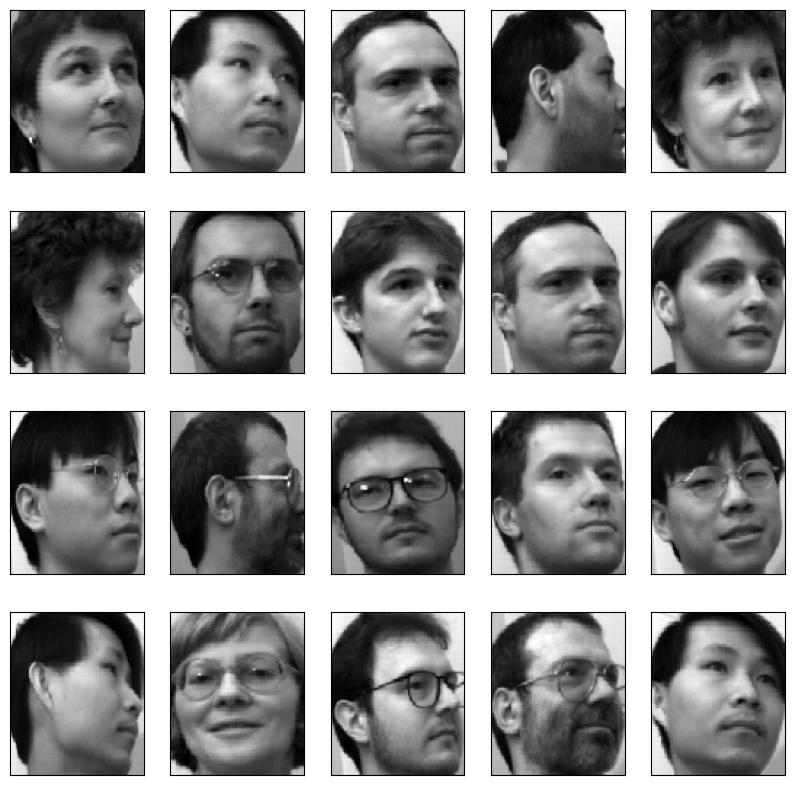

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i in range(0,20):
    fig.add_subplot(4,5,i+1)
    plt.imshow(x_test[i].reshape(112,92), cmap='gray')
    plt.xticks([])
    plt.yticks([])



In [8]:

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


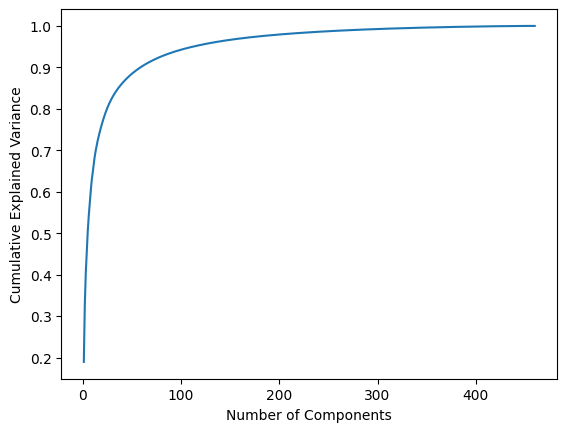

In [9]:
from sklearn.decomposition import PCA

# Assuming 'X' is your data
pca = PCA()
pca.fit(x_train)

import matplotlib.pyplot as plt

# Plotting cumulative explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [10]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
n_components_99

274

In [11]:

pca_final = PCA(n_components=289)   # n_components found experimentally
x_train_pca = pca_final.fit_transform(x_train)
print(f'Explained variance: {sum(pca.explained_variance_ratio_)}')
x_test_pca = pca.transform(x_test)


Explained variance: 0.9999999999999993


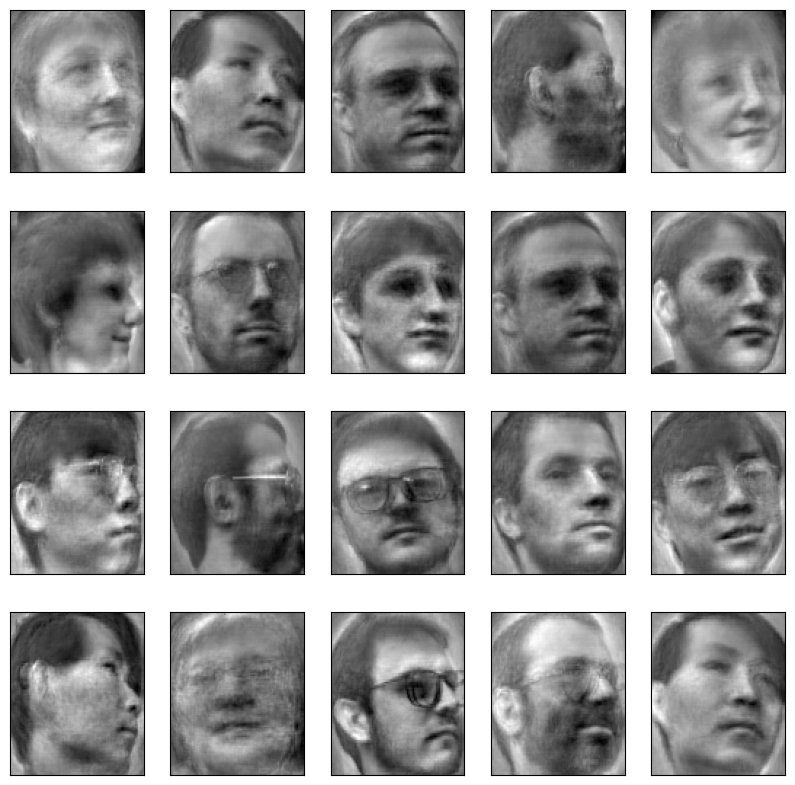

In [12]:
inverse = pca.inverse_transform(x_test_pca)   # Face images in the stratified training set, 0 to 344
fig = plt.figure(figsize=(10, 10))
for i in range(0,20):
    fig.add_subplot(4,5,i+1)

    plt.imshow(np.array(inverse[i]).reshape(112,92), cmap='gray')
    plt.xticks([])
    plt.yticks([])



/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

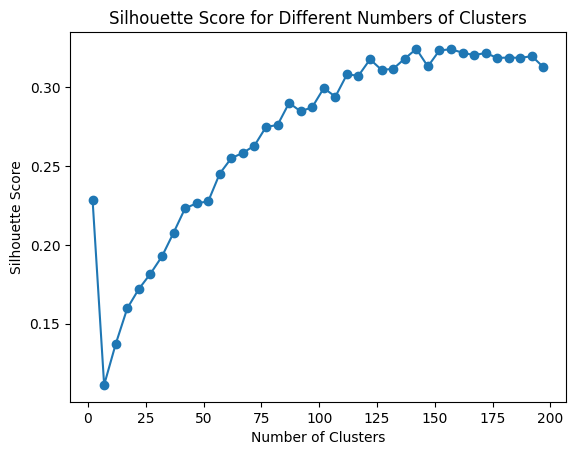

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

silhouette_scores = []
kmeans_models = []
cluster_range = range(2, 200,5)
# Iterate over different cluster numbers
for n_clusters in cluster_range:
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(x_train_pca)

    # Predict cluster labels
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(x_train_pca, labels)
    silhouette_scores.append(silhouette_avg)

    # Store the KMeans model
    kmeans_models.append(kmeans)

# Plotting the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()


In [14]:



x_train_images = x_train.reshape(-1,112,92,1)


In [15]:
x_train_images.shape

(460, 112, 92, 1)

In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop
model = keras.models.Sequential([


    tf.keras.layers.Conv2D(filters= 32 ,kernel_size = (5,5),padding = 'Same',activation = 'relu', input_shape=(112,92,1)),

    tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)),


    tf.keras.layers.Conv2D(filters= 64 ,kernel_size = (3,3),padding = 'Same',activation = 'relu'),
    tf.keras.layers.Conv2D(filters= 64 ,kernel_size = (3,3),padding = 'Same',activation = 'relu'),

    tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)),


    tf.keras.layers.Conv2D(filters= 128 ,kernel_size = (3,3),padding = 'Same',activation = 'relu'),
    tf.keras.layers.Conv2D(filters= 128 ,kernel_size = (3,3),padding = 'Same',activation = 'relu'),

    tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="sigmoid"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(512, activation="sigmoid"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(256, activation="sigmoid"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(20, activation="softmax")



])


In [17]:
x_train_images.shape

(460, 112, 92, 1)

In [18]:
from tensorflow.keras.optimizers import Adam, RMSprop
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    shear_range=15,
    zoom_range=0.10,
    validation_split=0.25,
    horizontal_flip=False,
    vertical_flip=False)

datagen.fit(x_train_images)

In [20]:
from keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=2,factor=0.5, min_lr=0.00001)

In [21]:
history = model.fit(datagen.flow(x_train_images, y_train, batch_size = 86), epochs = 100
         ,callbacks=[lrr], verbose = 2)

Epoch 1/100
6/6 - 4s - loss: 3.1119 - accuracy: 0.0543 - lr: 0.0010 - 4s/epoch - 739ms/step
Epoch 2/100
6/6 - 4s - loss: 2.8752 - accuracy: 0.1565 - lr: 0.0010 - 4s/epoch - 621ms/step
Epoch 3/100
6/6 - 4s - loss: 2.6661 - accuracy: 0.2087 - lr: 0.0010 - 4s/epoch - 585ms/step
Epoch 4/100
6/6 - 4s - loss: 2.4464 - accuracy: 0.2891 - lr: 0.0010 - 4s/epoch - 610ms/step
Epoch 5/100
6/6 - 4s - loss: 2.2793 - accuracy: 0.3435 - lr: 0.0010 - 4s/epoch - 640ms/step
Epoch 6/100
6/6 - 4s - loss: 2.0812 - accuracy: 0.3935 - lr: 0.0010 - 4s/epoch - 644ms/step
Epoch 7/100
6/6 - 4s - loss: 1.9592 - accuracy: 0.4109 - lr: 0.0010 - 4s/epoch - 629ms/step
Epoch 8/100
6/6 - 5s - loss: 1.8530 - accuracy: 0.4217 - lr: 0.0010 - 5s/epoch - 835ms/step
Epoch 9/100
6/6 - 15s - loss: 1.7948 - accuracy: 0.4304 - lr: 0.0010 - 15s/epoch - 3s/step
Epoch 10/100
6/6 - 6s - loss: 1.6846 - accuracy: 0.4848 - lr: 0.0010 - 6s/epoch - 938ms/step
Epoch 11/100
6/6 - 4s - loss: 1.6043 - accuracy: 0.4870 - lr: 0.0010 - 4s/epoch 

In [22]:

!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-Applications -y
!pip install tensorflow
!pip install keras-tuner
import tensorflow as tf

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)


**I've tried using the keras tuner**

In [25]:
#HyperParamter tuning

import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter

mat_data = sio.loadmat("umist_cropped.mat")

face_data = mat_data['facedat'][0]
data, label = [], []
for idx, person in enumerate(face_data):
    for i in range(person.shape[2]):
        img = person[:, :, i]
        img = img.reshape(-1)
        data.append(img)
        label.append(idx)


data, label = np.array(data), np.array(label)
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, stratify=label)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


num_components = min(x_train.shape[1], x_train.shape[0] - 1)
pca_final = PCA(n_components=num_components)
x_train_pca = pca_final.fit_transform(x_train)
x_test_pca = pca_final.transform(x_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

def build_model(hp):
    model = keras.Sequential()


    model.add(tf.keras.layers.Reshape((x_train_pca.shape[1],), input_shape=(x_train_pca.shape[1],)))

    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'dense_units_{i}', min_value=64, max_value=512, step=64),
                                       activation=hp.Choice(f'activation_{i}', values=['relu', 'sigmoid'])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(20, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,  # Increase the number of trials for a more comprehensive search also reduce for quicker training
    directory='hyperparamter tuning',
    project_name='facial_recognition'
)


tuner.search(x_train_pca, y_train, batch_size=86, epochs=100, validation_data=(x_test_pca, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


final_model = tuner.hypermodel.build(best_hps)


final_model.fit(x_train_pca, y_train, epochs=100, batch_size=86, validation_data=(x_test_pca, y_test))



Reloading Tuner from hyperparamter tuning/facial_recognition/tuner0.json


Epoch 1/100
6/6 [==============================] - 1s 37ms/step - loss: 3.3011 - accuracy: 0.1848 - val_loss: 3.1624 - val_accuracy: 0.0609
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4671 - accuracy: 0.5500 - val_loss: 3.1065 - val_accuracy: 0.0609
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.8665 - accuracy: 0.7152 - val_loss: 3.0352 - val_accuracy: 0.0609
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5985 - accuracy: 0.8065 - val_loss: 2.9527 - val_accuracy: 0.0609
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3820 - accuracy: 0.8804 - val_loss: 2.8662 - val_accuracy: 0.1043
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3219 - accuracy: 0.8891 - val_loss: 2.7817 - val_accuracy: 0.1217
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2098 - accuracy: 0.9413 - val_loss: 2.7021 - val_accuracy: 0.1652
Epoch 8/100
6/6 [========

In [26]:

# Evaluate the model on the test set
test_loss, test_accuracy = final_model.evaluate(x_test_pca, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predictions on the test set
y_pred = final_model.predict(x_test_pca)

# Convert one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate recall for each class
recall_per_class = []
for i in range(20):
    true_positive = np.sum((y_true_labels == i) & (y_pred_labels == i))
    actual_positive = np.sum(y_true_labels == i)
    recall = true_positive / actual_positive if actual_positive > 0 else 0
    recall_per_class.append(recall)

# Print recall for each class
for i, recall in enumerate(recall_per_class):
    print(f"Class {i + 1} Recall: {recall:.4f}")

# Calculate and print confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_true_labels, y_pred_labels, num_classes=20)
print("\nConfusion Matrix:")
print(confusion_matrix.numpy())

4/4 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9826

Test Accuracy: 0.9826
4/4 [==============================] - 0s 1ms/step
Class 1 Recall: 1.0000
Class 2 Recall: 1.0000
Class 3 Recall: 0.8000
Class 4 Recall: 1.0000
Class 5 Recall: 1.0000
Class 6 Recall: 0.8000
Class 7 Recall: 1.0000
Class 8 Recall: 1.0000
Class 9 Recall: 1.0000
Class 10 Recall: 1.0000
Class 11 Recall: 1.0000
Class 12 Recall: 1.0000
Class 13 Recall: 1.0000
Class 14 Recall: 1.0000
Class 15 Recall: 1.0000
Class 16 Recall: 1.0000
Class 17 Recall: 1.0000
Class 18 Recall: 1.0000
Class 19 Recall: 1.0000
Class 20 Recall: 1.0000

Confusion Matrix:
[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0